# load data

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")
    # get the data by myself
    df = pd.read_csv('/home/henryliu/Documents/ve450/analytics-zoo/data/nyc_taxi.csv')

nyc_taxi.csv doesn't exist
you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv


In [4]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, val_split_ratio=0.1, test_split_ratio=0.1)

Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.9.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


# train and validation

In [5]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henryliu/anaconda3/envs/zoo-

In [6]:
import ray
ray.init()

2019-10-16 21:45:50,953	INFO resource_spec.py:205 -- Starting Ray with 2.0 GiB memory available for workers and up to 1.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '10.167.213.65',
 'redis_address': '10.167.213.65:21504',
 'object_store_address': '/tmp/ray/session_2019-10-16_21-45-50_952430_4347/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-10-16_21-45-50_952430_4347/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-10-16_21-45-50_952430_4347'}

In [7]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   recipe=MTNetSmokeRecipe(),
                   metric="mean_squared_error")
print("Training completed.")

2019-10-16 21:45:51,885	WARNING worker.py:352 -- WARNING: Falling back to serializing objects of type <class 'zoo.automl.feature.time_sequence.TimeSequenceFeatureTransformer'> by using pickle. This may be inefficient.


Model selection: MTNet model is selected
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/2.0 GiB heap, 0.0/0.68 GiB objects
Memory usage on this node: 10.2/15.4 GiB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/12 CPUs, 0/1 GPUs, 0.0/2.0 GiB heap, 0.0/0.68 GiB objects
Memory usage on this node: 10.3/15.4 GiB
Result logdir: /home/henryliu/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_highway_window=2,n=3:	RUNNING

(pid=4394) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=4388) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=4392) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=4392) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/pyt

(pid=4388) preprocessing
(pid=4388) building
(pid=4388) 2019-10-16 21:46:00.335532: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=4388) 2019-10-16 21:46:00.357023: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
(pid=4388) 2019-10-16 21:46:00.358003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5634170cc0 executing computations on platform Host. Devices:
(pid=4388) 2019-10-16 21:46:00.358024: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
(pid=4388) 2019-10-16 21:46:00.646896: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is a

2019-10-16 21:46:04,710	INFO tune.py:274 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/2.0 GiB heap, 0.0/0.68 GiB objects
Memory usage on this node: 11.5/15.4 GiB
Result logdir: /home/henryliu/ray_results/automl
Number of trials: 1 ({'TERMINATED': 1})
TERMINATED trials:
 - train_func_0_highway_window=2,n=3:	TERMINATED, [2 CPUs, 0 GPUs], [pid=4388], 10 s, 1 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/2.0 GiB heap, 0.0/0.68 GiB objects
Memory usage on this node: 11.5/15.4 GiB
Result logdir: /home/henryliu/ray_results/automl
Number of trials: 1 ({'TERMINATED': 1})
TERMINATED trials:
 - train_func_0_highway_window=2,n=3:	TERMINATED, [2 CPUs, 0 GPUs], [pid=4388], 10 s, 1 iter

The best configurations are:
selected_features : ['MONTH(datetime)', 'WEEKDAY(datetime)', 'DAY(datetime)', 'HOUR(datetime)', 'IS_WEEKEND(datetime)', 'IS_AWAKE(datetime)', 'IS_BUSY_HOURS(datetime)']
n : 3
highway_window : 2
lr : 0.001
batch_size : 100
epochs : 

Training completed.
CPU times: user 7.11 s, sys: 280 ms, total: 7.39 s
Wall time: 19.9 s


In [8]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [9]:
# evaluate test_df
mse, rs = pipeline.evaluate(test_df, metrics=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_squared value is", rs)

Evaluate: the mean square error is [80146171.99474517]
Evaluate: the r_squared value is [-0.41107104]


## for testing purpose this example use unreasonable small scale of hyperparameter so result is awful

/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


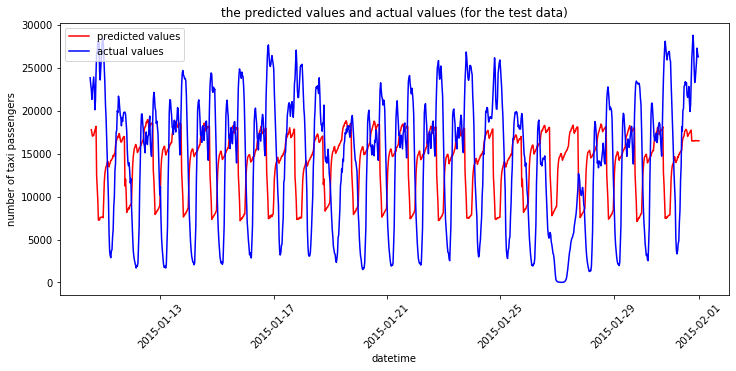

In [10]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)